In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, InputLayer, Flatten, BatchNormalization
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError, BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# Data Preparation

In [2]:
dataset, dataset_info = tfds.load('malaria', with_info= True, as_supervised= True, shuffle_files= True, split=['train'])

In [3]:
TRAIN_RATIO = 0.6
VAL_RATIO = 0.2
TEST_RATIO = 0.2

In [4]:
def split(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):

  DATASET_SIZE = len(dataset)
  train_dataset = dataset.take(int(TRAIN_RATIO * DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO * DATASET_SIZE))

  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))

  return train_dataset, val_dataset, test_dataset

In [32]:
train_dataset, val_dataset, test_dataset = split(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
# print(list(train_dataset.as_numpy_iterator()))
# print(list(val_dataset.as_numpy_iterator()))
# print(list(test_dataset.as_numpy_iterator()))

# Data Visualization

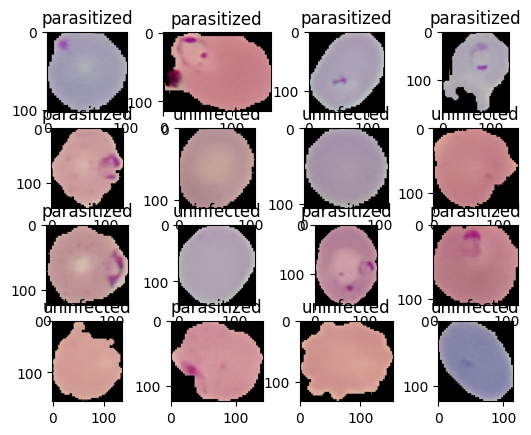

In [6]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))

# Data Processing

also we need to resize the images to fix size

there are 2 options standardizing the datas and normalizing the datas

if the images revolves around a particular mean value then we need to use standardization
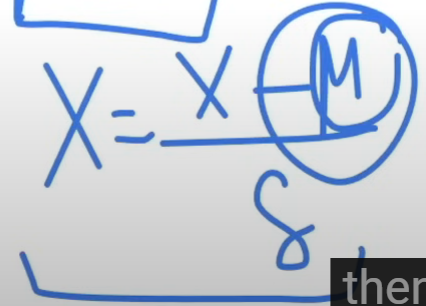


but if the data is or image sizes are mostly different from each other then we would want to normalize

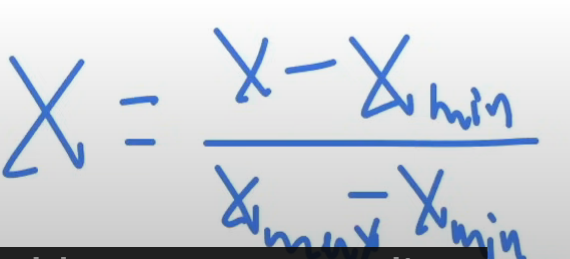

In [7]:
for x in train_dataset.take(1):
    print(type(x))
    if isinstance(x, tuple):
        print("Image shape:", x[0].shape)
        print("Label:", x[1])
    else:
        print("Sample shape:", x.shape)

<class 'tuple'>
Image shape: (103, 103, 3)
Label: tf.Tensor(0, shape=(), dtype=int64)


In [26]:
IM_SIZE = 224
def resizing_rescale(image,label):
  return  tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [33]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

In [10]:
for image,label in train_dataset.take(1):
  print(image, label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [34]:
train_dataset = train_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = val_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.shuffle(buffer_size= 8, reshuffle_each_iteration= True).batch(32).prefetch(tf.data.AUTOTUNE)

In [29]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

# Modelling

BatchNormalization - values of the same batch are standardize

In [13]:
lenet_model = tf.keras.Sequential([
    InputLayer(shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = 6, kernel_size = 5, strides = 1 , padding = 'valid', activation = 'relu' ),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Conv2D(filters = 16, kernel_size = 5, strides = 1 , padding = 'valid', activation = 'relu' ),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides = 2),

    Flatten(),

    Dense(100, activation = "relu"),
    BatchNormalization(),
    Dense(10, activation = "relu"),
    BatchNormalization(),
    Dense(1, activation = "sigmoid"),


])

lenet_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 220, 220, 6)    │            24 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 6)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 16)   │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 106, 106, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 44944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     4,494,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,010 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 10)             │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,498,921 (17.16 MB)

 Trainable params: 4,498,657 (17.16 MB)

 Non-trainable params: 264 (1.03 KB)

In [14]:
lenet_model.compile(
    optimizer = Adam(learning_rate = 0.01),
    loss = BinaryCrossentropy(),
    metrics = ['accuracy']
)

In [15]:
history = lenet_model.fit(train_dataset, validation_data= val_dataset, epochs= 20, verbose = 1)

Epoch 1/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 45s 76ms/step - accuracy: 0.6913 - loss: 0.5949 - val_accuracy: 0.8195 - val_loss: 0.5860
Epoch 2/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.9284 - loss: 0.2112 - val_accuracy: 0.7738 - val_loss: 0.4122
Epoch 3/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 35s 67ms/step - accuracy: 0.9492 - loss: 0.1542 - val_accuracy: 0.9338 - val_loss: 0.2138
Epoch 4/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 39s 75ms/step - accuracy: 0.9506 - loss: 0.1416 - val_accuracy: 0.9458 - val_loss: 0.1771
Epoch 5/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 35s 67ms/step - accuracy: 0.9504 - loss: 0.1366 - val_accuracy: 0.5001 - val_loss: 1.5030
Epoch 6/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.7526 - loss: 0.5054 - val_accuracy: 0.5795 - val_loss: 8.6039
Epoch 7/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 34s 66ms/step - accuracy: 0.9344 - loss: 0.1896 - val_accuracy: 0.9434 - val_loss: 0.1699
Epoch 8/20
517/517 ━━━━━━━━━━━━━━━━━━━━ 34s 67ms/step - accuracy: 0.9448 - loss: 0.1587 - 

/tmp/ipython-input-19-200543154.py:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('train_loss', 'val_loss')


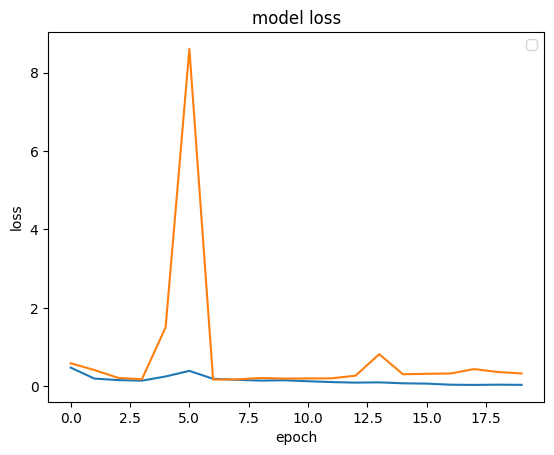

In [19]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train_loss', 'val_loss')
plt.show()

/tmp/ipython-input-21-1673357819.py:6: UserWarning: Legend does not support handles for str instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  plt.legend('train',  'val_accuracy')


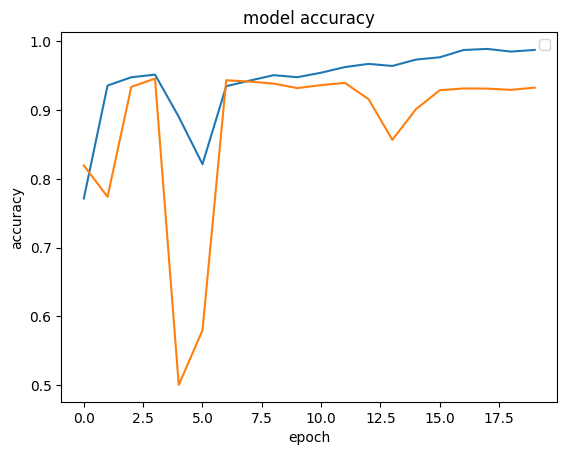

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend('train',  'val_accuracy')
plt.show()

# Model Evaluation and Testing

In [36]:
lenet_model.evaluate(test_dataset)

173/173 ━━━━━━━━━━━━━━━━━━━━ 15s 33ms/step - accuracy: 0.9352 - loss: 0.3114


[0.32583335041999817, 0.932704508304596]

In [39]:
def parasite_or_not(x):
  if(x < 0.5):
    return str('P')

  else:
    return str('U')

In [40]:
parasite_or_not(lenet_model.predict(test_dataset.take(1))[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


'P'

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


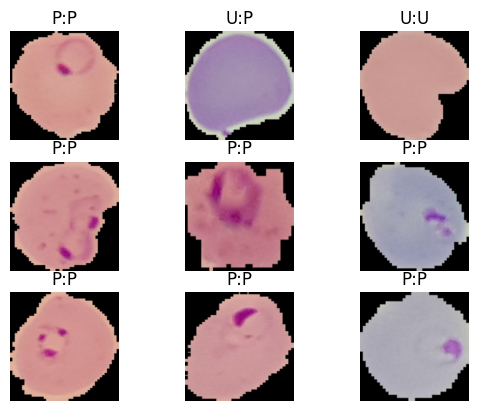

In [41]:
for i, (image, label) in enumerate(test_dataset.take(9)):

  ax = plt.subplot( 3, 3, i+1)
  plt.imshow(image[0])
  plt.title(str(parasite_or_not(label.numpy()[0])) + ":" +str(parasite_or_not(lenet_model.predict(image)[0][0])))

  plt.axis('off')